#### The Viterbi Algorithm
Ayush Jamdar EE20B018

In Question 4, I generalize the Viterbi Algorithm such that it works for M-ary PAM with any L-tap channel. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [2]:
def get_r(I_k, V_k, channel_f):
    '''
    This function models the transmission of a symbol sequence over an L-tap channel.
    
    I_k : The input symbol sequence.
    V_k : The noise sequence to be added to the transmitted signal.
    channel_f (list): The coefficients of the L-tap channel.

    r_k : The received signal sequence.
    '''
    
    # Determine the number of taps in the channel
    L = len(channel_f)
    
    # Pad the input symbol sequence with zeros at the beginning to account for the delay introduced by the channel
    I_k_padded = np.concatenate((np.zeros(len(channel_f)-1), I_k))
    
    # Convolve the padded input symbol sequence with the channel coefficients
    # The 'same' option is used to return the central part of the convolution that is the same size as I_k
    # The slicing operation selects only those parts of the convolution result that correspond to valid symbol periods
    r_k = np.convolve(I_k_padded, channel_f, 'same')[np.ceil((L-1)/2).astype(int) : -np.floor((L-1)/2).astype(int)]
    
    # Add the noise sequence to the transmitted signal
    r_k += V_k  
    
    return r_k


In [3]:
def tm_helper(nodes_sliced, channel_f):
    r_hat_k = np.zeros(nodes_sliced.shape[0])
    for i in range(nodes_sliced.shape[1]):
        r_hat_k += nodes_sliced[:, i] * channel_f[i]

    r_hat_k = r_hat_k.reshape(-1, 1)
    return r_hat_k

# t = np.array([[-1, -1], [1, -1], [-1, 1], [1, 1]])
# tm_helper(t[:, -2:].reshape(4, -1), channel_f*np.sqrt(2))

In [4]:
def convolve_with_channel(sequence, channel_f):
    # sequence_padded = np.concatenate((np.zeros(len(channel_f)-1), sequence))
    sequence = sequence[::-1] # reverse
    convolved_seq = np.convolve(sequence, channel_f, 'valid')[0]
    return convolved_seq

# convolve_with_channel(np.array([1, 2, 3, 4]), np.array([1, 1, 1, 1]))
# convolve_with_channel(np.array([-1.3416/3] + [-1.3416]*2), np.array([0.8, -1, 0.6] / np.sqrt(2)))

0.12648726101864954

In [5]:
def get_best_symbol_node_indices(transition_metric, L):
    ''' 
    This function is designed for a 4-PAM modulation scheme and an L-tap channel.
    It determines the best previous node indices for each current node in the trellis diagram.
    
    transition_metric : The transition metric values for the trellis diagram.
    L (int): The number of taps in the channel.

    best_symbol_indices : An array where each element signifies the best previous node index for that node.
    '''
    
    n_nodes = transition_metric.shape[0]
    M = transition_metric.shape[1]
    best_symbol_indices = []
    
    # Iterate over each possible symbol in M-PAM
    for i in range(M ** (L-2)):
        # Gather the transition metrics for all paths leading to nodes associated with symbol 'i'
        paths_at_nodes = np.array([transition_metric[i + (M**(L-2))*j] for j in range(M)])
        
        # Determine the indices of the paths with the smallest metric (best paths)
        # Map these indices to correspond to a M^(L-1)x1 matrix
        best_path_to_nodes = (np.argmin(paths_at_nodes, axis=0).reshape((M, 1))) * (M**(L-2)) + i  
        
        best_symbol_indices.append(best_path_to_nodes)
    
    # Reshape the list of best path indices to a M^(L-1)x1 numpy array
    best_symbol_indices = np.array(best_symbol_indices).reshape((n_nodes, 1))
    
    return best_symbol_indices


In [6]:
def viterbi(r_k, d, M, channel_f, sigma, N_sym, delta=30):
    ''' 
    Here the MLSE is performed using the Viterbi Algorithm
    The function is written for M-PAM with an L-tap channel

    input: d is half of d_min, r_k is the received sequence
    output: the MLSE sequence for r_k
    
    delta must be > 2
    '''

    symbols_half = np.array([d+2*d*j for j in range(M//2)])
    symbols = np.concatenate((symbols_half[::-1] * (-1), symbols_half))

    L = len(channel_f)
    n_nodes = M ** (L-1) # number of nodes in Trellis

    # generate the r_hat matrix    
    # nodes = np.array([[(i, s) for i in symbols] for s in symbols]).reshape(n_nodes, L-1)
    nodes = np.fliplr(np.array(list(product(symbols, repeat=L-1))))

    r_hat = np.array([
                    #   [(channel_f[0]*s + channel_f[1]*node[0] + channel_f[2]*node[1]) for s in symbols] 
                    #   for node in nodes
                        [convolve_with_channel(np.concatenate((np.array([s]), node)), channel_f) for s in symbols]
                        for node in nodes
                    ])
    
    # print("r_hat", r_hat)

    # Now, start the algorithm
    # we need to maintain a survivor seq and cumulative metric
    cumulative_metric = np.zeros((n_nodes, 1)) 
    
    for j in range(L-1):
        # loop until the trellis is ready
        # here we compute transition metrics and update the cumulative metric vector
        # we need to do this
        # f0 * nodes[-1] for j = 1
        # f1 * nodes[-1] + f0 * nodes[-2] for j = 2
        # f2 * nodes[-1] + f1 * nodes[-2] + f0 * nodes[-3] for j = 3
        # and so on
        transition_metric = (tm_helper(nodes[:, -j-1:], channel_f) - r_k[j]) ** 2
        cumulative_metric += transition_metric
    # print("Cumulative metric Init: \n", cumulative_metric)
    # now initialize the survivor seqs matrix0
    survivor_seqs = np.fliplr(nodes)
    
    mlse_seq = np.zeros((N_sym, 1))

    for i in range(L-1, N_sym):
        if i % 10000 == 0:
            print("Iter: ", i)

        # print("Iteration: ", i)
        transition_metric = (r_hat - r_k[i]) ** 2
        tm_plus_cm = transition_metric + cumulative_metric # 16x4
        # print("TM + CM: \n", tm_plus_cm)
        # print("TM: \n", transition_metric)
        best_symbol_node_indices = get_best_symbol_node_indices(tm_plus_cm, L) # this should be 16x1
        # print("Best symbol node indices: \n", best_symbol_node_indices)
        
        # now we need to select the best sequence
        survivor_seqs_new = []
        cumulative_metric_new = np.zeros((n_nodes, 1))
        
        # now add the best transition metric to the cumulative metric
        for j in range(n_nodes):
            new_seq = np.append(survivor_seqs[best_symbol_node_indices[j][0], :], symbols[j % M])
            survivor_seqs_new.append(new_seq)
            cumulative_metric_new[j] = (
                                    (cumulative_metric + transition_metric)[best_symbol_node_indices[j], j % M]
                                )
        
        cumulative_metric = cumulative_metric_new
        
        # print("cumulative metric: \n", cumulative_metric)
        survivor_seqs = np.array(survivor_seqs_new)

        if i >= delta:
            mlse_seq[i-delta] = survivor_seqs[np.argmin(cumulative_metric), 0]
            survivor_seqs = survivor_seqs[:, 1:]

        if i == N_sym-1:
            mlse_seq[i-delta+1:] = survivor_seqs[-1, :].reshape((delta, 1))
            # here we use the information that the last two symbols are 3d and 3d
        
        # print("Survivor seqs: \n", survivor_seqs)

    return mlse_seq.reshape((N_sym, ))

#### Question 4
(4.1) $M = 2$ and $L = 6$


In [8]:
# 2d is the minimum distance in 4-PAM
e_bit = 1
d = 1 
N_sym = 100004
channel_f = [1, -0.95, 0.5, 0.15, -0.2, -0.1]
L = len(channel_f)
channel_f /= np.linalg.norm(channel_f) # C

I_k = np.random.choice([-d, d], size=N_sym-(L-1))
# I_k = np.array((-3*d, -d, d, -d))
I_k = np.append(I_k, np.array([d]*(L-1))) # these will be used for decoding
snr_range = np.arange(0, 20, 2)
sigma_range = np.sqrt(e_bit*(10**(-snr_range/10)))

In [9]:
# deltas = [3, 6, 10, 20, 40]
# SER = {delta: [] for delta in deltas}
# M = 4
delta = 30
M = 2
SER = []

# for delta in deltas:
for sigma in sigma_range:
    print("Delta = ", delta, "| Sigma = ", sigma)
    noise = np.random.normal(0, sigma, size=N_sym)
    r_k = get_r(I_k, noise, channel_f)
    mlse_sequence = viterbi(r_k, d, M, channel_f, sigma, N_sym, delta)
    error_indices = np.where(mlse_sequence[:-(L-1)] != I_k[:-(L-1)])[0]
    error_count = len(error_indices)
    error_rate = error_count / (N_sym-L)
    SER.append(error_rate)
    print("Error Rate = ", SER[-1])

Delta =  30 | Sigma =  1.0
Iter:  10000
Iter:  20000
Iter:  30000
Iter:  40000
Iter:  50000
Iter:  60000
Iter:  70000
Iter:  80000
Iter:  90000
Iter:  100000
Error Rate =  0.22997459949198984
Delta =  30 | Sigma =  0.7943282347242815
Iter:  10000
Iter:  20000
Iter:  30000
Iter:  40000
Iter:  50000
Iter:  60000
Iter:  70000
Iter:  80000
Iter:  90000
Iter:  100000
Error Rate =  0.1882537650753015
Delta =  30 | Sigma =  0.6309573444801932
Iter:  10000
Iter:  20000
Iter:  30000
Iter:  40000
Iter:  50000
Iter:  60000
Iter:  70000
Iter:  80000
Iter:  90000
Iter:  100000
Error Rate =  0.13291265825316506
Delta =  30 | Sigma =  0.5011872336272722
Iter:  10000
Iter:  20000
Iter:  30000
Iter:  40000
Iter:  50000
Iter:  60000
Iter:  70000
Iter:  80000
Iter:  90000
Iter:  100000
Error Rate =  0.08099161983239665
Delta =  30 | Sigma =  0.39810717055349726
Iter:  10000
Iter:  20000
Iter:  30000
Iter:  40000
Iter:  50000
Iter:  60000
Iter:  70000
Iter:  80000
Iter:  90000
Iter:  100000
Error Rate =  

(4.3) Truncated Impulse Response 
First three taps of G(z) are taken. 

In [10]:
channel_f_43 = channel_f[0:3]
L_43 = len(channel_f_43)

delta = 30
M = 2
SER_43 = []

# for delta in deltas[-1:]:
for sigma in sigma_range:
    print("Delta = ", delta, "| Sigma = ", sigma)
    noise = np.random.normal(0, sigma, size=N_sym)
    r_k = get_r(I_k, noise, channel_f) # measurements have all taps
    mlse_sequence = viterbi(r_k, d, M, channel_f_43, sigma, N_sym, delta)
    error_indices = np.where(mlse_sequence[:-(L_43-1)] != I_k[:-((L_43-1))])[0]
    error_count = len(error_indices)
    error_rate = error_count / (N_sym-L_43)
    SER_43.append(error_rate)
    print("Error Rate = ", error_rate)

Delta =  30 | Sigma =  1.0
Iter:  10000
Iter:  20000
Iter:  30000
Iter:  40000
Iter:  50000
Iter:  60000
Iter:  70000
Iter:  80000
Iter:  90000
Iter:  100000
Error Rate =  0.23268767312326877
Delta =  30 | Sigma =  0.7943282347242815
Iter:  10000
Iter:  20000
Iter:  30000
Iter:  40000
Iter:  50000
Iter:  60000
Iter:  70000
Iter:  80000
Iter:  90000
Iter:  100000
Error Rate =  0.1979380206197938
Delta =  30 | Sigma =  0.6309573444801932
Iter:  10000
Iter:  20000
Iter:  30000
Iter:  40000
Iter:  50000
Iter:  60000
Iter:  70000
Iter:  80000
Iter:  90000
Iter:  100000
Error Rate =  0.15122848771512284
Delta =  30 | Sigma =  0.5011872336272722
Iter:  10000
Iter:  20000
Iter:  30000
Iter:  40000
Iter:  50000
Iter:  60000
Iter:  70000
Iter:  80000
Iter:  90000
Iter:  100000
Error Rate =  0.0981890181098189
Delta =  30 | Sigma =  0.39810717055349726
Iter:  10000
Iter:  20000
Iter:  30000
Iter:  40000
Iter:  50000
Iter:  60000
Iter:  70000
Iter:  80000
Iter:  90000
Iter:  100000
Error Rate =  0

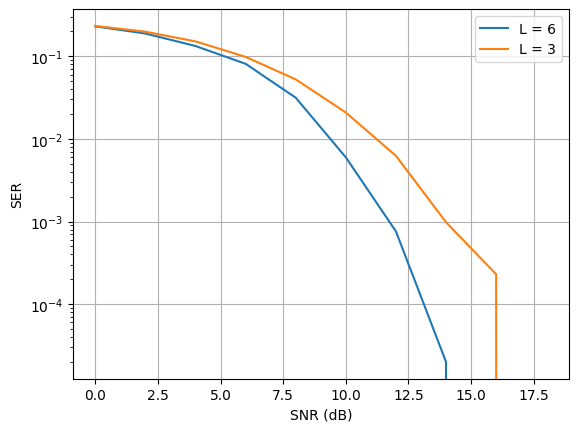

In [11]:
# now plot both SERs together
plt.semilogy(snr_range, SER, label="L = 6")
plt.semilogy(snr_range, SER_43, label="L = 3")
plt.xlabel("SNR (dB)")
plt.ylabel("SER")
plt.legend()
plt.grid()
plt.show()